# Анализ причинно-следственных связей по Грейнджеру: Температура и Демография/ДТП в Москве

Этот ноутбук реализует пайплайн для анализа причинно-следственных связей между временными рядами температуры и выбранным вторичным показателем (смертность или ДТП) для Москвы, используя тест Грейнджера.

## 1. Инициализация и Загрузка Библиотек

In [2]:
import sys
import os
import warnings

# Добавляем директорию src в путь Python
# Это необходимо, чтобы импортировать наши модули
if os.path.basename(os.getcwd()) != 'src':
    # Если ноутбук запускается из корня проекта
    if os.path.exists('src'):
        sys.path.append('src')
        print(f"Добавили 'src' в sys.path. Текущая директория: {os.getcwd()}")
    else:
        # Попытка подняться на уровень выше, если мы внутри src
        if os.path.exists('../src'):
             sys.path.append('..')
             print(f"Добавили '..' в sys.path. Текущая директория: {os.getcwd()}")
        else:
             print("Не удалось найти директорию 'src'. Убедитесь, что ноутбук находится в корне проекта или в 'src'.")
else:
    # Если ноутбук уже в src, добавляем родительскую директорию для доступа к data
    sys.path.append('..')
    print(f"Ноутбук в 'src'. Добавили '..' в sys.path.")

# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown # Для красивого вывода в Jupyter

# Импорт модулей проекта
import config
from data_processing import loader, cleaner, merger
from analysis import stationarity, var_model, granger
from visualization import time_series, diagnostics
from utils import logger, helpers

# Настройки отображения
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
warnings.filterwarnings('ignore') # Подавляем предупреждения для чистоты вывода

# Настройка стиля графиков (из config)
try:
    plt.style.use(config.PLOT_STYLE)
except Exception as e:
    print(f"Не удалось применить стиль графиков из config: {e}. Используется стиль по умолчанию.")

# Настройка логирования (опционально для ноутбука)
# log = logger.setup_logger(use_file=False) # Вывод только в консоль
# log.info("Запуск анализа в Jupyter Notebook")
print("Библиотеки и модули успешно импортированы.")

Ноутбук в 'src'. Добавили '..' в sys.path.
Библиотеки и модули успешно импортированы.


## 2. Загрузка Конфигурации

Загружаем и отображаем основные параметры анализа из файла `config.py`.

In [3]:
display(Markdown("### Параметры Анализа:"))
print(f"Файл данных температуры: {config.TEMP_DATA_PATH}")
print(f"Файл вторичных данных: {config.SECONDARY_DATA_PATH}")
print(f"Название вторичных данных: {config.SECONDARY_DATA_NAME}")
print(f"Формат даты для агрегации: {config.DATE_FORMAT}")
print(f"Метод нормализации (Температура): {config.NORMALIZATION_METHOD_TEMP}")
print(f"Метод нормализации (Вторичные данные): {config.NORMALIZATION_METHOD_SECONDARY}")
print(f"Агрегация (Температура): {config.AGGREGATION_TEMP}")
print(f"Агрегация (Вторичные данные): {config.AGGREGATION_SECONDARY}")
print(f"Максимальный порядок дифференцирования: {config.MAX_DIFFERENCING_ORDER}")
print(f"Максимальный лаг для VAR: {config.MAX_LAG_ORDER}")
print(f"Критерии выбора лага: {config.LAG_SELECTION_CRITERIA}")
print(f"Уровень значимости (ADF): {config.ADF_SIGNIFICANCE_LEVEL}")
print(f"Уровень значимости (KPSS): {config.KPSS_SIGNIFICANCE_LEVEL}")
print(f"Уровень значимости (Granger): {config.GRANGER_SIGNIFICANCE_LEVEL}")
print(f"Интерактивные графики: {config.INTERACTIVE_PLOTS}")

### Параметры Анализа:

Файл данных температуры: ../data/Moscow_Temp (2010-2024).csv
Файл вторичных данных: ../data/Moscow/moscow_mortality.csv
Название вторичных данных: Mortality
Формат даты для агрегации: %Y-%m
Метод нормализации (Температура): z-score
Метод нормализации (Вторичные данные): log
Агрегация (Температура): mean
Агрегация (Вторичные данные): sum
Максимальный порядок дифференцирования: 2
Максимальный лаг для VAR: 12
Критерии выбора лага: ['aic', 'bic']
Уровень значимости (ADF): 0.05
Уровень значимости (KPSS): 0.05
Уровень значимости (Granger): 0.05
Интерактивные графики: False


## 3. Загрузка Данных

Загружаем исходные временные ряды температуры и выбранного вторичного показателя.

In [4]:
try:
    df_temp_raw, df_secondary_raw = loader.load_all_data(config.TEMP_DATA_PATH, config.SECONDARY_DATA_PATH)

    display(Markdown("### Исходные данные температуры (первые 5 строк):"))
    display(df_temp_raw.head())
    df_temp_raw.info()

    display(Markdown(f"### Исходные данные '{config.SECONDARY_DATA_NAME}' (первые 5 строк):"))
    display(df_secondary_raw.head())
    df_secondary_raw.info()

except Exception as e:
    print(f"Ошибка при загрузке данных: {e}")
    # Прерываем выполнение или обрабатываем ошибку
    raise

Loading temperature data from: ../data/Moscow_Temp (2010-2024).csv
Temperature data loaded successfully.
Loading secondary data from: ../data/Moscow/moscow_mortality.csv
Mortality data loaded successfully.


### Исходные данные температуры (первые 5 строк):

,Date,Temperature,Precipitation
0,2010-01-01,-9.6,0.2
1,2010-01-02,-13.2,0.0
2,2010-01-03,-17.2,0.0
3,2010-01-04,-18.0,0.2
4,2010-01-05,-11.9,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5387 entries, 0 to 5386
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           5387 non-null   datetime64[ns]
 1   Temperature    5387 non-null   float64       
 2   Precipitation  5387 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 126.4 KB


### Исходные данные 'Mortality' (первые 5 строк):

,Date,Mortality
0,2010-01-01,10430
1,2010-02-01,9573
2,2010-03-01,10528
3,2010-04-01,9501
4,2010-05-01,9482


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       124 non-null    datetime64[ns]
 1   Mortality  124 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.1 KB


## 4. Предобработка Данных

Выполняем шаги предобработки:
1.  **Унификация временных меток:** Приведение дат к формату `YYYY-MM` и установка в качестве индекса.
2.  **Агрегация:** Расчет среднемесячной температуры и суммарных/средних значений для вторичного показателя.
3.  **Нормализация:** Применение Z-score стандартизации или логарифмирования.

### 4.1 Обработка данных температуры

In [5]:
# Важно: Укажите правильные имена колонок из ваших файлов!
# Имена колонок после обработки в loader.py
TEMP_DATE_COL = 'Date' 
TEMP_VALUE_COL = 'Temperature' 

try:
    # Шаг 1: Унификация временных меток
    # Убедитесь, что колонка TEMP_DATE_COL существует и содержит корректные даты
    df_temp_processed = cleaner.unify_timestamps(df_temp_raw.copy(), date_col=TEMP_DATE_COL, target_format=config.DATE_FORMAT)

    # Проверим, есть ли дубликаты в индексе
    if df_temp_processed.index.has_duplicates:
        print(f"Обнаружены дубликаты в индексе ({df_temp_processed.index.duplicated().sum()} штук). Агрегируем их...")
        # Группируем по индексу (по дате) и применяем агрегацию (например, 'mean')
        # Это создаст уникальный индекс перед месячной агрегацией.
        # Используйте нужную вам функцию агрегации (mean, median, sum, first, last и т.д.)
        df_temp_processed = df_temp_processed.groupby(level=0).mean() # level=0 означает группировку по индексу
        # Или, если вы хотите использовать ту же агрегацию, что и для месяца:
        # df_temp_processed = df_temp_processed.groupby(level=0).agg(config.AGGREGATION_TEMP)
        print("Дубликаты в индексе агрегированы.")

    # Шаг 2: Агрегация
    # Убедитесь, что колонка TEMP_VALUE_COL существует
    df_temp_agg = cleaner.aggregate_monthly(df_temp_processed, value_col=TEMP_VALUE_COL, agg_func=config.AGGREGATION_TEMP)

    # Шаг 3: Нормализация
    df_temp_norm = cleaner.normalize_data(df_temp_agg, method=config.NORMALIZATION_METHOD_TEMP)
    df_temp_norm.name = "Temperature_Norm"

    display(Markdown("#### Обработанные данные температуры (первые 5 строк):"))
    display(df_temp_norm.head())
    print(f"\nКоличество записей: {len(df_temp_norm)}")

except KeyError as e:
    print(f"Ошибка: Колонка {e} не найдена. Проверьте имена колонок TEMP_DATE_COL и TEMP_VALUE_COL.")
    raise
except Exception as e:
    print(f"Ошибка при обработке данных температуры: {e}")
    raise

Unifying timestamps for column: Date
Timestamps unified and set as index.
Обнаружены дубликаты в индексе (5210 штук). Агрегируем их...
Дубликаты в индексе агрегированы.
Aggregating column 'Temperature' monthly using 'mean'
Converting PeriodIndex to DatetimeIndex for aggregation.
Aggregation complete.
Normalizing series using method: z-score


#### Обработанные данные температуры (первые 5 строк):

Month
2010-01-31   -2.188679
2010-02-28   -1.570865
2010-03-31   -0.826430
2010-04-30    0.131968
2010-05-31    0.986622
Freq: ME, Name: Temperature_Norm, dtype: float64


Количество записей: 177


### 4.2 Обработка вторичных данных

In [6]:
# Важно: Укажите правильные имена колонок из ваших файлов!
# Имена колонок после обработки в loader.py (для mortality.csv)
SECONDARY_DATE_COL = 'Date' 
SECONDARY_VALUE_COL = 'Mortality' # Используем 'Mortality' т.к. это default в config
# Если будете использовать DTP, измените SECONDARY_VALUE_COL на 'DTP'

try:
    # Шаг 1: Унификация временных меток
    df_secondary_processed = cleaner.unify_timestamps(df_secondary_raw.copy(), date_col=SECONDARY_DATE_COL, target_format=config.DATE_FORMAT)

    # Шаг 2: Агрегация
    df_secondary_agg = cleaner.aggregate_monthly(df_secondary_processed, value_col=SECONDARY_VALUE_COL, agg_func=config.AGGREGATION_SECONDARY)

    # Шаг 3: Нормализация
    df_secondary_norm = cleaner.normalize_data(df_secondary_agg, method=config.NORMALIZATION_METHOD_SECONDARY)
    df_secondary_norm.name = f"{config.SECONDARY_DATA_NAME}_Norm"

    display(Markdown(f"#### Обработанные данные '{config.SECONDARY_DATA_NAME}' (первые 5 строк):"))
    display(df_secondary_norm.head())
    print(f"\nКоличество записей: {len(df_secondary_norm)}")

except KeyError as e:
    print(f"Ошибка: Колонка {e} не найдена. Проверьте имена колонок SECONDARY_DATE_COL и SECONDARY_VALUE_COL.")
    raise
except Exception as e:
    print(f"Ошибка при обработке вторичных данных: {e}")
    raise

Unifying timestamps for column: Date
Timestamps unified and set as index.
Aggregating column 'Mortality' monthly using 'sum'
Converting PeriodIndex to DatetimeIndex for aggregation.
Aggregation complete.
Normalizing series using method: log


#### Обработанные данные 'Mortality' (первые 5 строк):

Month
2010-01-31    9.252442
2010-02-28    9.166702
2010-03-31    9.261794
2010-04-30    9.159152
2010-05-31    9.157151
Freq: ME, Name: Mortality_Norm, dtype: float64


Количество записей: 124


### 4.3 Объединение данных

Объединяем обработанные ряды в один DataFrame, используя внутреннее соединение (`inner`) для сохранения только пересекающихся временных периодов.

In [7]:
try:
    df_merged = merger.merge_dataframes(df_temp_norm.to_frame(), df_secondary_norm.to_frame(), how='inner')

    display(Markdown("#### Объединенные данные (первые 5 строк):"))
    display(df_merged.head())
    print(f"\nИтоговое количество записей: {len(df_merged)}")
    print(f"Временной диапазон: {df_merged.index.min()} - {df_merged.index.max()}")

    # Проверка на пропуски после объединения
    merger.check_completeness(df_merged)

except Exception as e:
    print(f"Ошибка при объединении данных: {e}")
    raise

Merging dataframes using method: inner
DataFrames merged successfully.


#### Объединенные данные (первые 5 строк):

,Temperature_Norm,Mortality_Norm
Month,,
2010-01-31,-2.188679,9.252442
2010-02-28,-1.570865,9.166702
2010-03-31,-0.826430,9.261794
2010-04-30,0.131968,9.159152
2010-05-31,0.986622,9.157151



Итоговое количество записей: 124
Временной диапазон: 2010-01-31 00:00:00 - 2020-04-30 00:00:00
Checking merged data completeness...
No missing values found.
Time series index is continuous (no gaps).


## 5. Визуализация Обработанных Рядов

Строим графики объединенных и нормализованных временных рядов.

Plotting time series: Обработанные и объединенные временные ряды


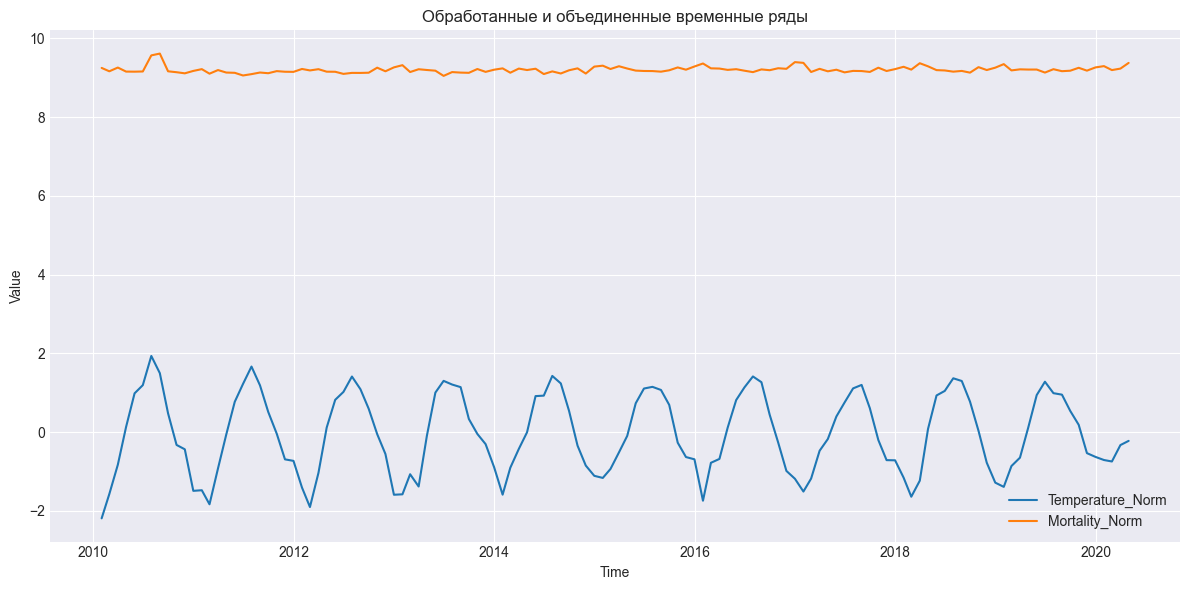

In [8]:
if config.INTERACTIVE_PLOTS:
    try:
        time_series.plot_time_series_interactive(df_merged, title="Обработанные и объединенные временные ряды (Интерактивно)")
    except Exception as e:
        print(f"Ошибка при построении интерактивного графика: {e}. Попробуем статический график.")
        time_series.plot_time_series(df_merged, title="Обработанные и объединенные временные ряды")
else:
    time_series.plot_time_series(df_merged, title="Обработанные и объединенные временные ряды")

## 6. Проверка Стационарности

Проверяем ряды на стационарность с помощью тестов ADF (Augmented Dickey-Fuller) и KPSS (Kwiatkowski-Phillips-Schmidt-Shin).

-   **ADF Тест:**
    -   H0: Ряд имеет единичный корень (нестационарен).
    -   H1: Ряд не имеет единичного корня (стационарен).
    -   *Ожидание:* p-value < уровня значимости (например, 0.05) для отклонения H0.
-   **KPSS Тест:**
    -   H0: Ряд стационарен относительно уровня или тренда.
    -   H1: Ряд имеет единичный корень (нестационарен).
    -   *Ожидание:* p-value >= уровня значимости (например, 0.05) для НЕотклонения H0.

Если ряды нестационарны, применяем дифференцирование и повторяем проверку.

In [9]:
display(Markdown("### Проверка стационарности исходных (объединенных) рядов:"))
stationarity_results_orig = stationarity.check_stationarity_on_dataframe(
    df_merged, 
    adf_level=config.ADF_SIGNIFICANCE_LEVEL, 
    kpss_level=config.KPSS_SIGNIFICANCE_LEVEL
)

# Анализ результатов и принятие решения о дифференцировании
needs_differencing = False
for col, results in stationarity_results_orig.items():
    # Считаем ряд нестационарным, если ADF не отвергает H0 ИЛИ KPSS отвергает H0
    if not results['ADF'][0] or not results['KPSS'][0]:
        needs_differencing = True
        print(f"\nРяд '{col}' вероятно нестационарен. Рекомендуется дифференцирование.")
        break # Достаточно одного нестационарного ряда для дифференцирования всего датафрейма

if needs_differencing:
    diff_order = 1 # Начинаем с первого порядка
    print(f"\nПрименяем дифференцирование порядка {diff_order}...")
    df_stationary = stationarity.apply_differencing(df_merged, order=diff_order)
    
    display(Markdown(f"### Проверка стационарности после дифференцирования (порядок {diff_order}):"))
    stationarity_results_diff = stationarity.check_stationarity_on_dataframe(
        df_stationary, 
        adf_level=config.ADF_SIGNIFICANCE_LEVEL, 
        kpss_level=config.KPSS_SIGNIFICANCE_LEVEL
    )
    # TODO: Добавить логику для повторного дифференцирования (order=2), если необходимо
    # Проверяем стационарность df_stationary и при необходимости применяем diff(2)
    still_needs_diff = False
    for col, results in stationarity_results_diff.items():
        if not results['ADF'][0] or not results['KPSS'][0]:
             still_needs_diff = True
             print(f"\nРяд '{col}' все еще может быть нестационарен после diff(1).")
             break
    if still_needs_diff and config.MAX_DIFFERENCING_ORDER >= 2:
         diff_order = 2
         print(f"\nПрименяем дифференцирование порядка {diff_order}...")
         # Применяем к исходному df_merged, а не к df_stationary
         df_stationary = stationarity.apply_differencing(df_merged, order=diff_order)
         display(Markdown(f"### Проверка стационарности после дифференцирования (порядок {diff_order}):"))
         stationarity.check_stationarity_on_dataframe(df_stationary, adf_level=config.ADF_SIGNIFICANCE_LEVEL, kpss_level=config.KPSS_SIGNIFICANCE_LEVEL)
    elif still_needs_diff:
         print(f"\nПредупреждение: Ряды могут быть нестационарны даже после дифференцирования максимального порядка ({config.MAX_DIFFERENCING_ORDER}). Результаты VAR/Granger могут быть ненадежными.")
else:
    print("\nВсе ряды стационарны. Дифференцирование не требуется.")
    df_stationary = df_merged.copy() # Используем исходные данные

display(Markdown("#### Итоговые данные для моделирования (первые 5 строк):"))
display(df_stationary.head())

### Проверка стационарности исходных (объединенных) рядов:


--- Checking Stationarity for: Temperature_Norm ---
Performing ADF test on series: Temperature_Norm (Regression: c)
ADF Test Results for Temperature_Norm:
  Test Statistic: -1.7241
  P-value: 0.4187
  Lags Used: 12
  Is Stationary (p < 0.05): False
Performing KPSS test on series: Temperature_Norm (Regression: c)
KPSS Test Results for Temperature_Norm:
  Test Statistic: 0.0159
  P-value: 0.1000 (Note: p-values are interpolated and may be capped at 0.01 or 0.1)
  Lags Used: 5
  Is Stationary (p >= 0.05): True

--- Checking Stationarity for: Mortality_Norm ---
Performing ADF test on series: Mortality_Norm (Regression: c)
ADF Test Results for Mortality_Norm:
  Test Statistic: -1.7729
  P-value: 0.3940
  Lags Used: 13
  Is Stationary (p < 0.05): False
Performing KPSS test on series: Mortality_Norm (Regression: c)
KPSS Test Results for Mortality_Norm:
  Test Statistic: 0.3510
  P-value: 0.0983 (Note: p-values are interpolated and may be capped at 0.01 or 0.1)
  Lags Used: 3
  Is Stationary 

### Проверка стационарности после дифференцирования (порядок 1):


--- Checking Stationarity for: Temperature_Norm ---
Performing ADF test on series: Temperature_Norm (Regression: c)
ADF Test Results for Temperature_Norm:
  Test Statistic: -9.3855
  P-value: 0.0000
  Lags Used: 11
  Is Stationary (p < 0.05): True
Performing KPSS test on series: Temperature_Norm (Regression: c)
KPSS Test Results for Temperature_Norm:
  Test Statistic: 0.0329
  P-value: 0.1000 (Note: p-values are interpolated and may be capped at 0.01 or 0.1)
  Lags Used: 5
  Is Stationary (p >= 0.05): True

--- Checking Stationarity for: Mortality_Norm ---
Performing ADF test on series: Mortality_Norm (Regression: c)
ADF Test Results for Mortality_Norm:
  Test Statistic: -5.0238
  P-value: 0.0000
  Lags Used: 12
  Is Stationary (p < 0.05): True
Performing KPSS test on series: Mortality_Norm (Regression: c)
KPSS Test Results for Mortality_Norm:
  Test Statistic: 0.2325
  P-value: 0.1000 (Note: p-values are interpolated and may be capped at 0.01 or 0.1)
  Lags Used: 31
  Is Stationary (

#### Итоговые данные для моделирования (первые 5 строк):

,Temperature_Norm,Mortality_Norm
Month,,
2010-02-28,0.617814,-0.085740
2010-03-31,0.744435,0.095092
2010-04-30,0.958397,-0.102641
2010-05-31,0.854654,-0.002002
2010-06-30,0.207870,0.004945


## 7. Визуализация Стационарных Рядов и ACF/PACF

Строим графики рядов после преобразований (если они применялись) и их автокорреляционные (ACF) и частично автокорреляционные (PACF) функции для визуальной оценки структуры зависимостей.

### Графики стационарных рядов:

Plotting time series: Стационарные временные ряды


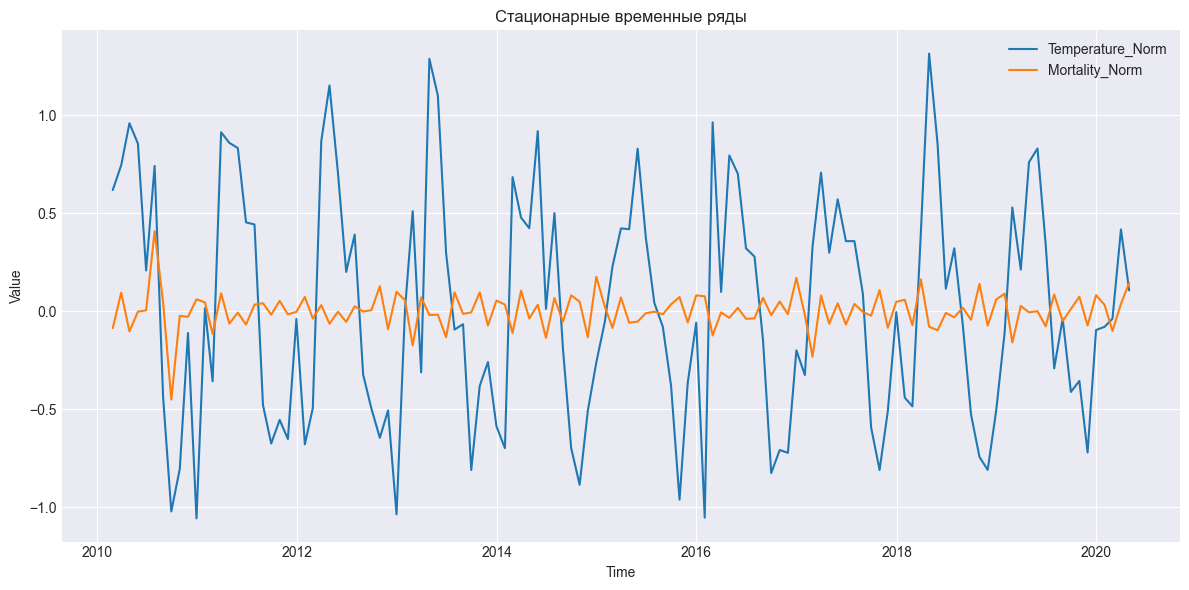

### Графики ACF/PACF для стационарных рядов:

Plotting ACF/PACF for: Temperature_Norm


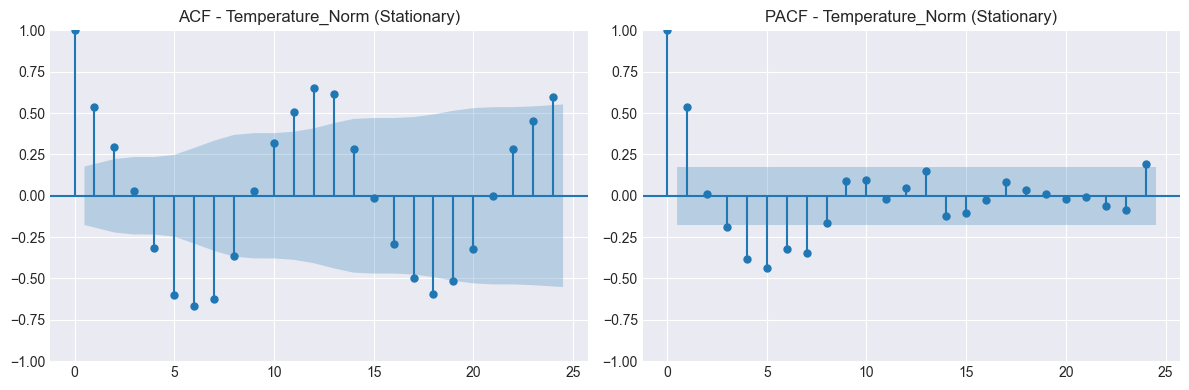

Plotting ACF/PACF for: Mortality_Norm


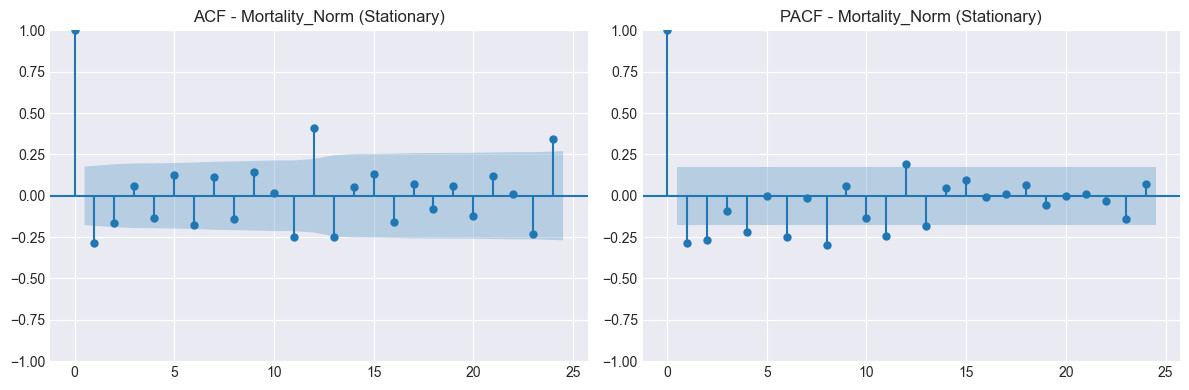

In [10]:
display(Markdown("### Графики стационарных рядов:"))
if config.INTERACTIVE_PLOTS:
    try:
        time_series.plot_time_series_interactive(df_stationary, title="Стационарные временные ряды (Интерактивно)")
    except Exception as e:
        print(f"Ошибка при построении интерактивного графика: {e}. Попробуем статический график.")
        time_series.plot_time_series(df_stationary, title="Стационарные временные ряды")
else:
    time_series.plot_time_series(df_stationary, title="Стационарные временные ряды")

display(Markdown("### Графики ACF/PACF для стационарных рядов:"))
acf_pacf_lags = 24 # Количество лагов для отображения
for col in df_stationary.columns:
    time_series.plot_acf_pacf(df_stationary[col], lags=acf_pacf_lags, title_suffix="(Stationary)")

## 8. Определение Оптимального Лага VAR Модели

Подбираем оптимальный порядок лага для модели векторной авторегрессии (VAR), используя информационные критерии (AIC, BIC и др.). Модель VAR описывает каждый временной ряд как линейную функцию от его собственных прошлых значений и прошлых значений других рядов в системе.

In [11]:
try:
    optimal_lags = var_model.select_optimal_lag(
        df_stationary, 
        max_lags=config.MAX_LAG_ORDER, 
        criteria=config.LAG_SELECTION_CRITERIA
    )
    
    # Выбор лага (например, по BIC, который обычно выбирает более парсимоничные модели)
    chosen_lag = optimal_lags.get('bic', -1)
    if chosen_lag == -1: # Если BIC не найден, пробуем AIC
        chosen_lag = optimal_lags.get('aic', -1)
        if chosen_lag != -1:
             print("\nBIC не найден, используем лаг по AIC.")
    
    if chosen_lag <= 0:
        print(f"\nПредупреждение: Оптимальный лаг ({chosen_lag}) не является положительным числом. VAR модель не может быть построена. Проверьте данные или увеличьте max_lags.")
        # Можно попробовать установить лаг вручную, например, 1, но это может быть некорректно
        # chosen_lag = 1 
        # print("Устанавливаем лаг = 1 вручную для продолжения анализа (результаты могут быть неточными).")
    else:
        print(f"\nВыбранный оптимальный лаг для VAR модели: {chosen_lag}")

except Exception as e:
    print(f"Ошибка при выборе оптимального лага: {e}")
    chosen_lag = -1 # Устанавливаем невалидный лаг при ошибке
    raise

Selecting optimal lag order (max_lags=12) using criteria: ['aic', 'bic']

Lag Selection Results Summary:
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -6.284      -6.235    0.001866      -6.264
1       -6.927      -6.780   0.0009813      -6.867
2       -7.191      -6.947   0.0007533      -7.092
3       -7.211      -6.869   0.0007390      -7.072
4       -7.389      -6.950   0.0006184      -7.211
5       -7.562      -7.025   0.0005207      -7.344
6       -7.706      -7.072   0.0004509      -7.449
7       -7.923      -7.190   0.0003636      -7.626
8       -8.170      -7.340   0.0002845      -7.833
9       -8.250      -7.323   0.0002630      -7.874
10      -8.247      -7.222   0.0002644      -7.831
11      -8.423      -7.300   0.0002225      -7.967
12     -8.587*     -7.366*  0.0001895*     -8.092*
--------------------------------------------------

Selected Optimal Lags:
  AI

## 9. Построение и Проверка VAR Модели

Строим VAR модель с выбранным оптимальным лагом и проверяем ее стабильность. Стабильность означает, что модель не будет генерировать взрывных прогнозов и является условием для корректной интерпретации импульсных откликов и результатов теста Грейнджера.

In [12]:
var_results = None
is_stable = False

if chosen_lag > 0:
    try:
        var_results = var_model.fit_var_model(df_stationary, lag_order=chosen_lag)
        if var_results:
            is_stable = var_model.check_model_stability(var_results)
            if not is_stable:
                print("\nПредупреждение: VAR модель нестабильна! Результаты теста Грейнджера и IRF могут быть некорректными.")
                print("Возможные причины: неправильный выбор лага, нестационарность данных (несмотря на тесты), структурные сдвиги.")
        else:
            print("Не удалось построить VAR модель.")
    except Exception as e:
        print(f"Ошибка при построении или проверке VAR модели: {e}")
else:
    print("Оптимальный лаг не выбран или некорректен, построение VAR модели пропускается.")

Fitting VAR model with lag order: 12

VAR Model Fit Summary:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 30, Mar, 2025
Time:                     19:53:16
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -7.36640
Nobs:                     111.000    HQIC:                  -8.09178
Log likelihood:           211.569    FPE:                0.000189486
AIC:                     -8.58691    Det(Omega_mle):     0.000126225
--------------------------------------------------------------------
Results for equation Temperature_Norm
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.009659         0.024040            0.402           0.688
L1.Temperature_Norm         -0.623453         0.

## 10. Тест Грейнджера на Причинно-Следственную Связь

Проводим тест Грейнджера, чтобы определить, помогает ли знание прошлых значений одного временного ряда предсказывать будущие значения другого ряда.

Формулировка гипотез (для `X -> Y`):
-   **H0:** Прошлые значения X **не** помогают предсказывать Y (X не является причиной Y по Грейнджеру).
-   **H1:** Прошлые значения X **помогают** предсказывать Y (X является причиной Y по Грейнджеру).

Мы ищем низкие p-value (меньше уровня значимости, например, 0.05), чтобы отвергнуть H0 и сделать вывод о наличии причинности по Грейнджеру.

In [13]:
granger_summary = None
if var_results:
    try:
        # Используем лаг, с которым была построена модель VAR
        granger_lag = var_results.k_ar 
        granger_results_dict = granger.perform_granger_causality_test(
            var_results, 
            max_lag=granger_lag, 
            significance_level=config.GRANGER_SIGNIFICANCE_LEVEL
        )
        
        if granger_results_dict:
            granger_summary = granger.summarize_granger_results(granger_results_dict)
            display(Markdown("### Результаты теста Грейнджера:"))
            display(granger_summary)
        else:
            print("Не удалось получить результаты теста Грейнджера.")

    except Exception as e:
        print(f"Ошибка при выполнении теста Грейнджера: {e}")
else:
    print("VAR модель не была успешно построена, тест Грейнджера пропускается.")


Performing Granger Causality Tests (max_lag=12, alpha=0.05)...
  Testing: Mortality_Norm Granger-causes Temperature_Norm?
    ssr_ftest: p-value=0.2296 (Not Significant)
    params_ftest: p-value=0.2296 (Not Significant)
  Testing: Temperature_Norm Granger-causes Mortality_Norm?
    ssr_ftest: p-value=0.0001 (Significant)
    params_ftest: p-value=0.0001 (Significant)


### Результаты теста Грейнджера:

,Effect,Lag,SSR_p_value,SSR_Significant,Params_p_value,Params_Significant,Details
0,Mortality_Norm -> Temperature_Norm,12,0.2296,False,0.2296,False,"F=1.31, df=(86, 12)"
1,Temperature_Norm -> Mortality_Norm,12,0.0001,True,0.0001,True,"F=3.89, df=(86, 12)"


## 11. Визуализация Диагностик Модели

Строим диагностические графики для анализа динамики взаимодействия между переменными:

-   **Импульсные Отклики (Impulse Response Functions - IRF):** Показывают реакцию одной переменной на шок (неожиданное изменение) в другой переменной на протяжении нескольких периодов времени.
-   **Декомпозиция Дисперсии Ошибок Прогноза (Forecast Error Variance Decomposition - FEVD):** Показывает, какая доля дисперсии ошибки прогноза каждой переменной объясняется шоками в других переменных (включая саму себя) на разных горизонтах прогнозирования.

### Графики Импульсных Откликов (IRF):

Plotting Impulse Response Functions (Periods: 24)...
  Plotting all IRFs.


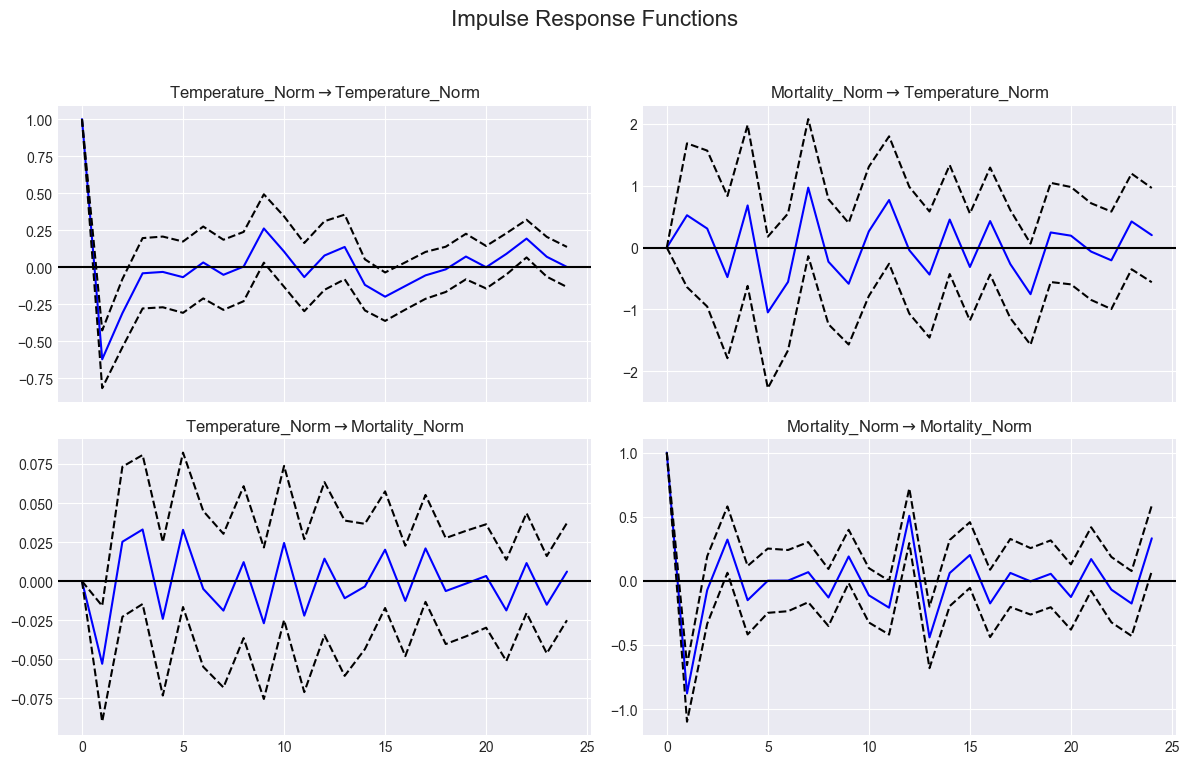

### Графики Декомпозиции Дисперсии Ошибок Прогноза (FEVD):

Plotting Forecast Error Variance Decomposition...


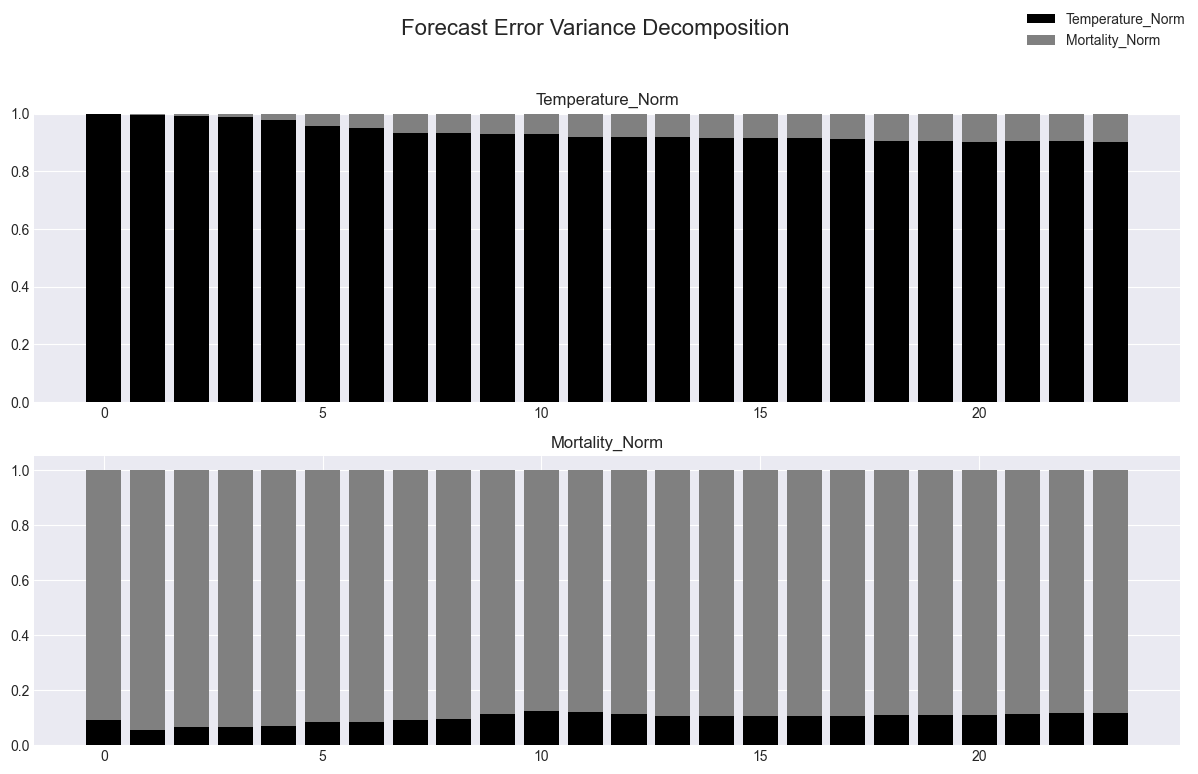

In [14]:
if var_results:
    plot_periods = 24 # Горизонт для IRF и FEVD
    display(Markdown("### Графики Импульсных Откликов (IRF):"))
    try:
        diagnostics.plot_impulse_response(var_results, periods=plot_periods)
    except Exception as e:
        print(f"Ошибка при построении IRF: {e}")
    
    display(Markdown("### Графики Декомпозиции Дисперсии Ошибок Прогноза (FEVD):"))
    try:
        diagnostics.plot_fevd(var_results, periods=plot_periods)
    except Exception as e:
        print(f"Ошибка при построении FEVD: {e}")
else:
    print("VAR модель не была успешно построена, диагностические графики пропускаются.")

# 12. Выводы и Интерпретация

## Выводы по Смертность и Температура (Temperature -> Mortality)

На основе проведенного анализа причинно-следственных связей по Грейнджеру между среднемесячной температурой и ежемесячной смертностью в Москве (с января 2010 по апрель 2020), можно сделать следующие выводы:

1.  **Стационарность:**
    *   Исходные временные ряды (после нормализации: z-score для температуры, log для смертности) оказались **нестационарными** по результатам тестов ADF и KPSS.
    *   Для достижения стационарности потребовалось применить **дифференцирование первого порядка (d=1)**. После этой операции оба ряда стали стационарными, что является необходимым условием для корректного применения VAR-модели и теста Грейнджера.

2.  **VAR Модель:**
    *   На основе информационных критериев AIC и BIC был выбран **оптимальный лаг p=12** для модели векторной авторегрессии (VAR). Такой высокий порядок лага для месячных данных может указывать на наличие значимых сезонных (годовых) зависимостей или долгосрочных эффектов в динамике температуры и смертности.
    *   Построенная модель VAR(12) прошла проверку на **стабильность**. Это означает, что модель адекватна и не будет генерировать "взрывных" прогнозов, а результаты теста Грейнджера, импульсных откликов (IRF) и декомпозиции дисперсии (FEVD) являются интерпретируемыми.

3.  **Причинность по Грейнджеру (Уровень значимости α = 0.05):**
    *   **Влияние Температуры на Смертность (Temperature\_Norm -> Mortality\_Norm):**
        *   **Результат:** p-value = 0.0001 (меньше 0.05).
        *   **Интерпретация:** Нулевая гипотеза (H0: "Температура НЕ является причиной смертности по Грейнджеру") **отвергается**. Это означает, что прошлые значения температуры (за период до 12 месяцев назад) содержат статистически значимую информацию, которая помогает предсказывать будущие значения смертности, помимо той информации, которая уже содержится в прошлых значениях самой смертности.
    *   **Влияние Смертности на Температуру (Mortality\_Norm -> Temperature\_Norm):**
        *   **Результат:** p-value = 0.2296 (больше 0.05).
        *   **Интерпретация:** Нулевая гипотеза (H0: "Смертность НЕ является причиной температуры по Грейнджеру") **не отвергается**. Это означает, что прошлые значения смертности не предоставляют статистически значимой дополнительной информации для предсказания будущих значений температуры.
    *   **Вывод по причинности:** Обнаружена **однонаправленная причинно-следственная связь по Грейнджеру**, идущая от температуры к смертности. Обратная связь статистически не значима.

4.  **IRF и FEVD (Интерпретация на основе стабильности модели и результатов Грейнджера):**
    *   **Импульсные Отклики (IRF):** Поскольку модель стабильна и обнаружена связь Temp -> Mort, график IRF должен показывать статистически значимую реакцию (положительную или отрицательную, в зависимости от знака коэффициентов и лага) показателя смертности на неожиданное изменение (шок) в температуре в прошлых периодах. Реакция температуры на шок в смертности, скорее всего, будет незначимой (доверительный интервал включает ноль). Для детального анализа формы и длительности реакции нужно смотреть сами графики IRF.
    *   **Декомпозиция Дисперсии (FEVD):** График FEVD для смертности должен показать, что доля дисперсии ошибки прогноза, объясняемая шоками температуры, вероятно, увеличивается с увеличением горизонта прогнозирования и становится заметной. В то же время, для температуры доля дисперсии, объясняемая шоками смертности, должна оставаться низкой на всех горизонтах.

5.  **Общий вывод:**
    Анализ предоставляет статистические доказательства в пользу гипотезы о том, что **изменения среднемесячной температуры в Москве в прошлом влияют на последующие изменения уровня ежемесячной смертности** в период с 2010 по 2020 год, в контексте предсказательной способности по Грейнджеру. Противоположное влияние (смертности на температуру) статистически не подтверждается, что соответствует логике изучаемых явлений. Этот результат подчеркивает важность температурных факторов для общественного здоровья и демографических показателей в городе.

**Как читать результаты:**

*   **Стационарность:** Важно убедиться, что ряды стационарны (или приведены к стационарности) перед тестом Грейнджера. Если нет - результаты ненадежны.
*   **VAR лаг (p):** Показывает, сколько прошлых периодов учитывается в модели. Лаг 12 означает учет годовой истории.
*   **Стабильность VAR:** Если модель стабильна, тест Грейнджера и IRF/FEVD корректны. Если нет - выводы делать нельзя.
*   **P-value (тест Грейнджера):** Если p-value < 0.05 (или выбранного уровня значимости), отвергаем H0 и заключаем, что "X является причиной Y по Грейнджеру". Если p-value >= 0.05, не отвергаем H0, т.е. нет статистических оснований утверждать о причинности по Грейнджеру.
*   **IRF:** Показывает (+/-) реакцию одной переменной на единичный шок в другой на N периодов вперед. Доверительные интервалы показывают значимость реакции.
*   **FEVD:** Показывает в % вклад шоков одной переменной в ошибку прогноза другой переменной на N периодов вперед.